# **Regression: Covid-19 Risk Prediction Notebook**

## Objectives

Fit and evaluate a regression model to predict the risk level for a Covid-19 patient based on their age and pre-existing health conditions.

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict Risk level of patient
* Labels map
* Feature Importance Plot 

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study'

---

## Load Data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/covid-19-dataset.csv")
df['DIED'] = df['DIED'].map({'Yes': 1, 'No': 0})
df = df.drop(labels=['USMER', 'MEDICAL_UNIT'], axis=1)

print(df.shape)
df.head(3)

(62236, 16)


,SEX,INTUBED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DIED
0,Male,No,No,76,No,No,No,No,Yes,Yes,No,No,No,No,No,0
1,Male,No,Yes,91,Yes,No,No,No,Yes,No,No,No,No,No,No,0
2,Male,No,Yes,39,No,No,No,No,No,No,No,No,No,No,Yes,1


---

### ML Pipeline: Regressor

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary',
            variables=['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA',
                       'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
                       'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']
        )),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
            variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])
    return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Hyperparameter Optimization

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

class HyperparameterOptimizationSearch(BaseEstimator):
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

#### Split Train Test Set

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(['DIED'], axis=1)
y = df['DIED']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (49788, 15) (49788,) 
* Test set: (12448, 15) (12448,)


### Grid Search CV - Sklearn

In [8]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {
        'model__C': [0.1, 1, 10],
        'model__solver': ['liblinear', 'lbfgs'],
        'model__max_iter': [100, 200]
    },
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

### Run Grid Search

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

                    estimator min_score mean_score max_score std_score  \
16  GradientBoostingRegressor    0.1601   0.163906  0.168607  0.002929   
14        ExtraTreesRegressor  0.156578   0.161011  0.165709  0.002981   
12      DecisionTreeRegressor  0.156578    0.16101  0.165709  0.002974   
13      RandomForestRegressor  0.156304   0.160965  0.165652  0.003019   
15          AdaBoostRegressor  0.156799   0.160084  0.164321  0.002845   
17               XGBRegressor  0.120535   0.123844  0.127833  0.002495   
1          LogisticRegression -0.284394  -0.270391 -0.262576  0.008429   
11         LogisticRegression -0.284394  -0.270391 -0.262576  0.008429   
10         LogisticRegression -0.284394  -0.270391 -0.262576  0.008429   
0          LogisticRegression -0.284394  -0.270391 -0.262576  0.008429   
8          LogisticRegression -0.284394  -0.270391 -0.262576  0.008429   
7          LogisticRegression -0.284394  -0.270391 -0.262576  0.008429   
6          LogisticRegression -0.28439

### Evaluate the Best Model

In [11]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

best_model = grid_search_summary.iloc[0, 0]
print("Best Model:", best_model)
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_

regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Best Model: GradientBoostingRegressor
Model Evaluation 

* Train Set
R2 Score: 0.167
Mean Absolute Error: 0.407
Mean Squared Error: 0.203
Root Mean Squared Error: 0.451


* Test Set
R2 Score: 0.165
Mean Absolute Error: 0.408
Mean Squared Error: 0.204
Root Mean Squared Error: 0.452




### Assess Feature Importance

* These are the 2 most important features in descending order. The model was trained on them: 
['INTUBED', 'AGE']


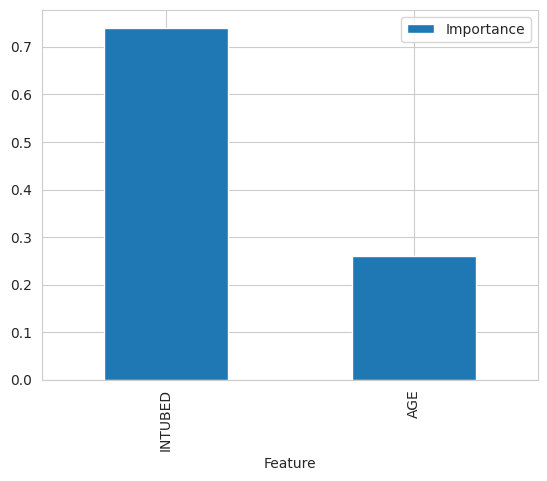

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

columns_after_data_cleaning_feat_eng = X_train.columns

df_feature_importance = pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_}
).sort_values(by='Importance', ascending=False)

print(f"* These are the {len(df_feature_importance)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.167
Mean Absolute Error: 0.407
Mean Squared Error: 0.203
Root Mean Squared Error: 0.451


* Test Set
R2 Score: 0.165
Mean Absolute Error: 0.408
Mean Squared Error: 0.204
Root Mean Squared Error: 0.452




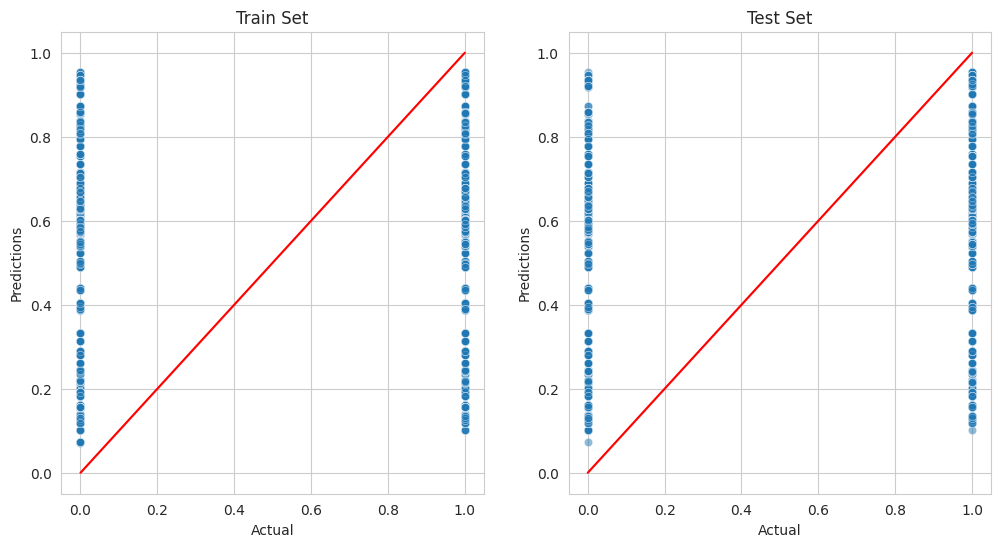

In [13]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()
    
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### Regressor with PCA

In [15]:
pipeline = PipelineOptimization(model=LogisticRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['DIED'], axis=1))
print(df_pca.shape, '\n', type(df_pca))

(62236, 15) 
 <class 'numpy.ndarray'>


Apply PCA

* The 15 components explain 100.0% of the data 



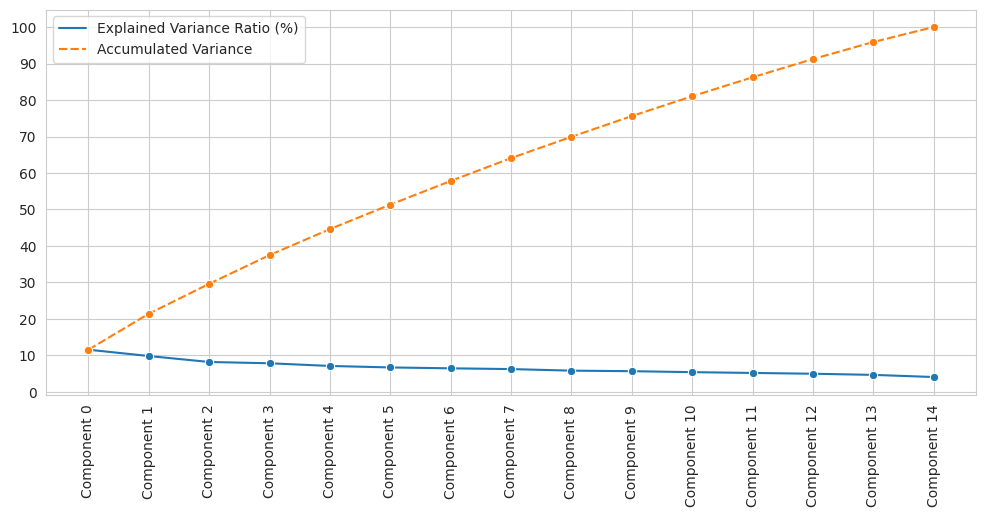

In [16]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 15


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) 

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 7 components explain 57.82% of the data 



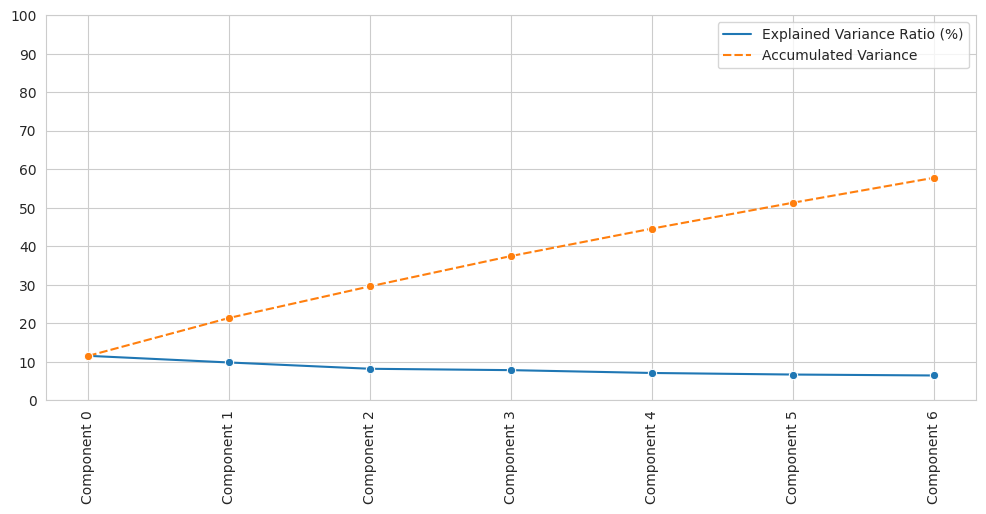

In [17]:
n_components = 7
pca_components_analysis(df_pca=df_pca, n_components=n_components)

### Rewrite ML Pipeline for Modelling

In [22]:
from sklearn.decomposition import PCA

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary',
            variables=['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA',
                       'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
                       'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']
        )),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base

### Grid Search CV – Sklearn

In [23]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (49788, 15) (49788,) 
* Test set: (12448, 15) (12448,)


Use standard hyperparameters to find the most suitable model.

In [24]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {
        'model__C': [0.1, 1, 10],
        'model__solver': ['liblinear', 'lbfgs'],
        'model__max_iter': [100, 200]
    },
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [25]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [26]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__C,model__max_iter,model__solver
16,GradientBoostingRegressor,0.133002,0.139191,0.146243,0.005038,NaN,NaN,NaN
17,XGBRegressor,0.112944,0.1205,0.130489,0.006759,NaN,NaN,NaN
15,AdaBoostRegressor,0.094389,0.099119,0.10428,0.00389,NaN,NaN,NaN
13,RandomForestRegressor,-0.078009,-0.070943,-0.065432,0.004464,NaN,NaN,NaN
14,ExtraTreesRegressor,-0.19353,-0.192464,-0.189299,0.001609,NaN,NaN,NaN
12,DecisionTreeRegressor,-0.337596,-0.332427,-0.318496,0.007081,NaN,NaN,NaN
3,LogisticRegression,-0.438982,-0.421544,-0.406555,0.012706,0.1,200,lbfgs
1,LogisticRegression,-0.438982,-0.421544,-0.406555,0.012706,0.1,100,lbfgs
10,LogisticRegression,-0.438982,-0.421708,-0.406967,0.012954,10,200,liblinear
11,LogisticRegression,-0.438982,-0.421708,-0.406967,0.012954,10,200,lbfgs


##### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

In [27]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10, None],
    }
}

In [28]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [29]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
1,GradientBoostingRegressor,0.138405,0.143312,0.150693,0.004572,0.1,3,300
0,GradientBoostingRegressor,0.133002,0.139191,0.146243,0.005038,0.1,3,100
9,GradientBoostingRegressor,0.125634,0.129155,0.13635,0.003908,0.01,10,300
7,GradientBoostingRegressor,0.119242,0.125216,0.131162,0.004646,0.01,3,300
8,GradientBoostingRegressor,0.119322,0.123995,0.129379,0.003489,0.01,10,100
2,GradientBoostingRegressor,0.104171,0.109449,0.116216,0.004652,0.1,10,100
6,GradientBoostingRegressor,0.091508,0.095205,0.099192,0.002953,0.01,3,100
15,GradientBoostingRegressor,0.065003,0.067273,0.069765,0.001851,0.001,10,300
3,GradientBoostingRegressor,0.049184,0.057859,0.07018,0.007322,0.1,10,300
13,GradientBoostingRegressor,0.046303,0.04728,0.04837,0.000839,0.001,3,300


In [30]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [31]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 300}

In [32]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['SEX', 'INTUBED', 'PNEUMONIA',
                                           'DIABETES', 'COPD', 'ASTHMA',
                                           'INMSUPR', 'HIPERTENSION',
                                           'OTHER_DISEASE', 'CARDIOVASCULAR',
                                           'OBESITY', 'RENAL_CHRONIC',
                                           'TOBACCO', 'ICU'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['SEX', 'INTUBED',
                                                     'PNEUMONIA', 'AGE',
                                                     'DIABETES', 'COPD',
            

#### Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.177
Mean Absolute Error: 0.409
Mean Squared Error: 0.201
Root Mean Squared Error: 0.448


* Test Set
R2 Score: 0.146
Mean Absolute Error: 0.418
Mean Squared Error: 0.209
Root Mean Squared Error: 0.457




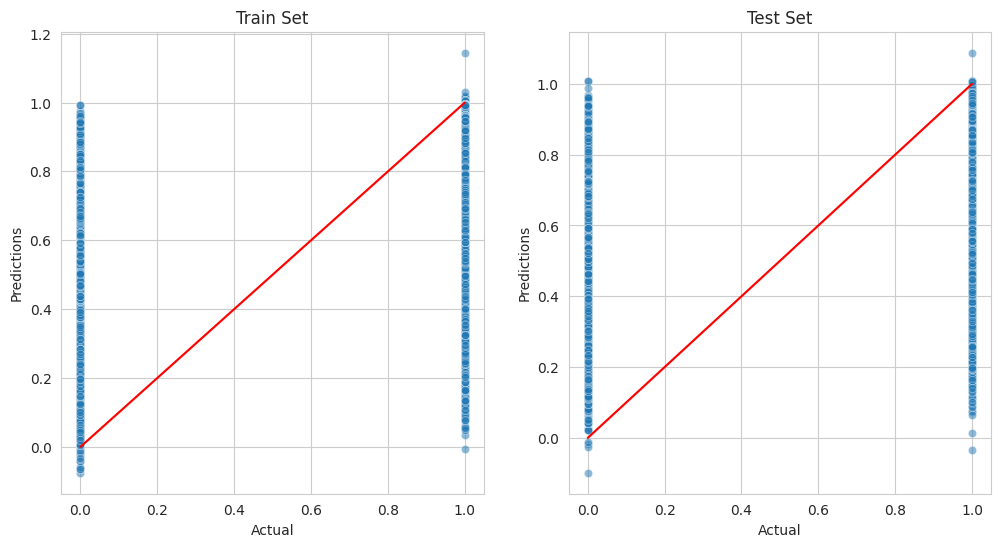

In [33]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

### Convert Regression to Classification

#### Convert numerical target to bins, and check if it is balanced

   AGE AGE_BINNED
0   76      70-80
1   91        90+
2   39      30-40
3   80      80-90
4   48      40-50


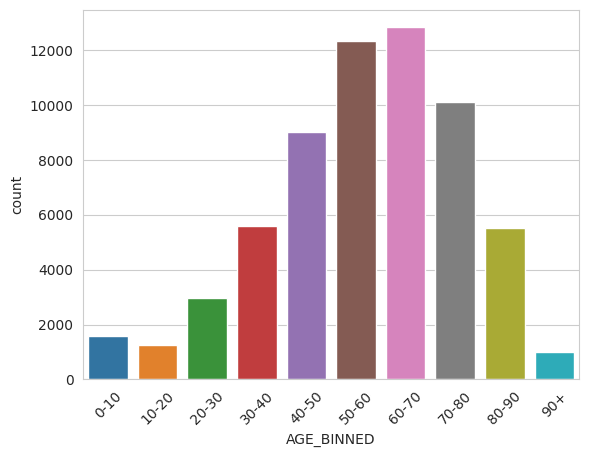

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bin_edges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = [f'{i}-{i+10}' for i in range(0, 90, 10)] + ['90+']

df['AGE_BINNED'] = pd.cut(df['AGE'], bins=bin_edges, labels=bin_labels, right=False)

print(df[['AGE', 'AGE_BINNED']].head())

sns.countplot(data=df, x='AGE_BINNED')
plt.xticks(rotation=45)
plt.show()

In [38]:
df_clf.head(3)

,SEX,INTUBED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DIED
0,Male,No,No,2,No,No,No,No,Yes,Yes,No,No,No,No,No,0
1,Male,No,Yes,2,Yes,No,No,No,Yes,No,No,No,No,No,No,0
2,Male,No,Yes,0,No,No,No,No,No,No,No,No,No,No,Yes,1


### Rewrite ML Pipeline for Modelling

In [39]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES',
                                                                'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION',
                                                                'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
                                                                'RENAL_CHRONIC', 'TOBACCO', 'ICU'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

#### Load algorithms for classification

In [40]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

#### Split Train Test Sets

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['DIED'], axis=1),
    df_clf['DIED'],
    test_size=0.2,
    random_state=0 
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (49788, 15) (49788,) 
* Test set: (12448, 15) (12448,)


### Grid Seach CV – Sklearn

#### Use standard hyper parameters to find most suitable model

In [42]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [43]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check Results

In [44]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,XGBClassifier,0.40466,0.418938,0.427247,0.007938
1,DecisionTreeClassifier,0.40466,0.418938,0.427247,0.007938
2,RandomForestClassifier,0.40466,0.418938,0.427247,0.007938
3,GradientBoostingClassifier,0.40466,0.418938,0.427247,0.007938
4,ExtraTreesClassifier,0.40466,0.418938,0.427247,0.007938
5,AdaBoostClassifier,0.240428,0.383884,0.492392,0.08681


##### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define models and parameters

In [45]:
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_search = {
    "AdaBoostClassifier": {
        'model__n_estimators': [50, 100, 300],
        'model__learning_rate': [1e-1, 1e-2, 1e-3],
    }
}

Extensive GridSearch CV

In [46]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Results

In [47]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
2,AdaBoostClassifier,0.240428,0.383884,0.492392,0.08681,0.1,300
5,AdaBoostClassifier,0.226819,0.373572,0.551486,0.123395,0.01,300
0,AdaBoostClassifier,0.240428,0.370855,0.427247,0.0734,0.1,50
1,AdaBoostClassifier,0.240428,0.37019,0.426397,0.072899,0.1,100
3,AdaBoostClassifier,0.0,0.169825,0.427247,0.207999,0.01,50
4,AdaBoostClassifier,0.0,0.169825,0.427247,0.207999,0.01,100
6,AdaBoostClassifier,0.0,0.169825,0.427247,0.207999,0.001,50
7,AdaBoostClassifier,0.0,0.169825,0.427247,0.207999,0.001,100
8,AdaBoostClassifier,0.0,0.169825,0.427247,0.207999,0.001,300


Check best model

In [48]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Parameters for best model

In [49]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1, 'model__n_estimators': 300}

Define the best clf pipeline

In [50]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['SEX', 'INTUBED', 'PNEUMONIA',
                                           'DIABETES', 'COPD', 'ASTHMA',
                                           'INMSUPR', 'HIPERTENSION',
                                           'OTHER_DISEASE', 'CARDIOVASCULAR',
                                           'OBESITY', 'RENAL_CHRONIC',
                                           'TOBACCO', 'ICU'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='vari...
                                          variables=['SEX', 'INTUBED',
                                                     'PNEUMONIA', 'AGE',
                                                     'DIABETES', 'COPD',
                                                     'ASTHMA', 'INMSUPR'

### Assess feature importance

We can assess feature importance for this model with .feature_importances_

* These are the 3 most important features in descending order. The model was trained on them: 
['AGE', 'PNEUMONIA', 'HIPERTENSION']


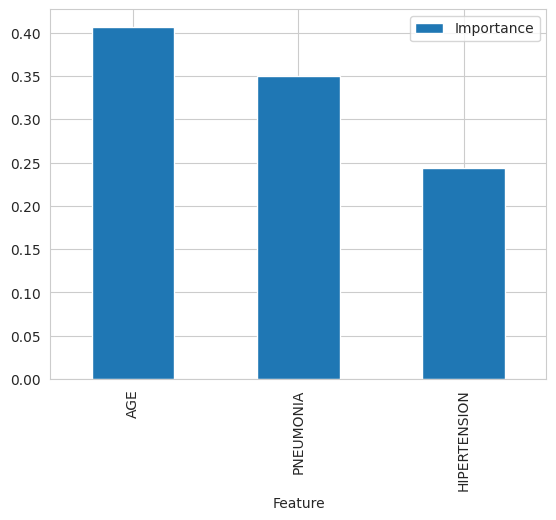

In [51]:
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Classifier on Train and Test Sets

Custom Function

In [64]:
from sklearn.metrics import classification_report, confusion_matrix


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

def confusion_matrix_and_report(X, y, pipeline, label_map):
    prediction = pipeline.predict(X)
    
    labels = sorted(set(y) | set(prediction))
    
    cm = confusion_matrix(y_true=y, y_pred=prediction, labels=labels)
    
    cm_df = pd.DataFrame(cm, columns=[f"Predicted {label}" for label in labels],
                            index=[f"Actual {label}" for label in labels])
    
    print('---  Confusion Matrix  ---')
    print(cm_df)
    print("\n")
    
    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=[str(label) for label in labels]))

In [65]:
disc.binner_dict_['AGE']

[-inf, 50.0, 66.0, inf]

In [66]:
label_map = bin_labels
print(label_map)

['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90+']


In [67]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map=label_map)

#### Train Set #### 

---  Confusion Matrix  ---
          Predicted 0  Predicted 1
Actual 0         8735        12292
Actual 1         3108        25653


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.74      0.42      0.53     21027
           1       0.68      0.89      0.77     28761

    accuracy                           0.69     49788
   macro avg       0.71      0.65      0.65     49788
weighted avg       0.70      0.69      0.67     49788

#### Test Set ####

---  Confusion Matrix  ---
          Predicted 0  Predicted 1
Actual 0         2154         3143
Actual 1          749         6402


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.74      0.41      0.53      5297
           1       0.67      0.90      0.77      7151

    accuracy                           0.69     12448
   macro avg       0.71      0.65      0.65     12448
weighted avg       0.70    

#### Which pipeline to choose?

We fitted 3 pipelines:

- Regression
- Regression with PCA
- Classifier

In [68]:
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['SEX', 'INTUBED', 'PNEUMONIA',
                                           'DIABETES', 'COPD', 'ASTHMA',
                                           'INMSUPR', 'HIPERTENSION',
                                           'OTHER_DISEASE', 'CARDIOVASCULAR',
                                           'OBESITY', 'RENAL_CHRONIC',
                                           'TOBACCO', 'ICU'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['SEX', 'INTUBED',
                                                     'PNEUMONIA', 'AGE',
                                                     'DIABETES', 'COPD',
            

#### Refit pipeline with best features

Rewrite Pipeline

In [ ]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Contract', 'PaymentMethod'])),

        ("feat_scaling", StandardScaler()),

        # feature selection is not needed

        ("model", model),

    ])

    return pipeline_base

#### Split Train Test Set, only with best features

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['DIED'], axis=1),
    df_clf['DIED'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (49788, 15) (49788,) 
* Test set: (12448, 15) (12448,)


Subset Best Features

In [71]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (49788, 3) (49788,) 
* Test set: (12448, 3) (12448,)


,AGE,PNEUMONIA,HIPERTENSION
8065,0,Yes,No
35341,0,Yes,No
56043,0,Yes,No


### Save the Model and Artifacts

In [14]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_severity/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/regressor_pipeline.pkl")
print(f'Model saved at {file_path}/regressor_pipeline.pkl')

X_train.to_csv(f"{file_path}/X_train.csv", index=False)
X_test.to_csv(f"{file_path}/X_test.csv", index=False)
y_train.to_csv(f"{file_path}/y_train.csv", index=False)
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_severity/v1'
Model saved at outputs/ml_pipeline/predict_severity/v1/regressor_pipeline.pkl


### Modelling pipeline

ML pipeline for predicting

In [ ]:
pipeline_clf

In [ ]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

#### List mapping target levels to ranges

Map for converting numerical variable to categorical variable

In [ ]:
label_map

In [ ]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

#### Feature importance plot

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')